In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pubchempy as pcp
import pandas as pd
from os import listdir, getcwd
from os.path import isfile, join
from torchvision.io import read_image
from torchvision.io.image import ImageReadMode
from torch.utils.data import Dataset, DataLoader, random_split


## 建立 Custom Image DataSet

從 PubChem 上下載會和 TK/ES 基因作用的所有 compound, 然後從中取得 CID 後利用 PubChemPy 下載分子結構圖

In [2]:
# tk_df = pd.read_csv("/Users/afrithero/Downloads/GeneID_7083_TK_bioactivity_gene.csv")
# tk_df = tk_df[tk_df.acvalue.notna()]
# tk_df = tk_df[tk_df.acvalue < 10]
# tk_cid = set(tk_df.cid)
# for i in tk_cid:
#     pcp.download('PNG', '/Users/afrithero/Downloads/CNN/compound_img/TK_{}.png'.format(i), i, 'cid')

In [3]:
# es_df = pd.read_csv("/Users/afrithero/Downloads/GeneID_2099_ES_bioactivity_gene.csv",low_memory=False)
# es_df = es_df[es_df.acvalue.notna()]
# es_df = es_df[es_df.acvalue < 10]
# es_df = es_df.iloc[0:68,:]
# es_cid = set(es_df.cid)
# for i in es_cid:
#     pcp.download('PNG', '/Users/afrithero/Downloads/CNN/compound_img/ES_{}.png'.format(i), i, 'cid')

建立 label 檔案

In [4]:
path = "./compound_img"
files_only = [file for file in listdir(path) if isfile(join(path, file))]
with open("./labels.csv", 'w') as csv_file:
    for file_name in files_only[:-1]:
        if "TK" in file_name:
            csv_file.write(file_name+",0\n")
        elif "ES" in file_name:
            csv_file.writelines(file_name+",1\n")
    if "TK" in files_only[-1]:
        csv_file.write(file_name+",0")
    elif "ES" in files_only[-1]:
        csv_file.writelines(file_name+",1")

定義類別

In [5]:
class CustomImageDataset(Dataset):
    def __init__(self, labels, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(labels,header=None)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path,mode=ImageReadMode.RGB)
        image = image.to(torch.float32)
        label = self.img_labels.iloc[idx, 1]

        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

讀取 label, 放圖的目錄還有建立 dataset

In [6]:
labels = "./labels.csv"
img_dir = "./compound_img"
kinase_inhibitor_datasets = CustomImageDataset(labels, img_dir)

劃分訓練集還有測試集

In [7]:
train_size = int(0.8 * len(kinase_inhibitor_datasets))
test_size = len(kinase_inhibitor_datasets) - train_size
training_data, testing_data = random_split(kinase_inhibitor_datasets, [train_size, test_size])

檢視有無成功讀取到圖檔

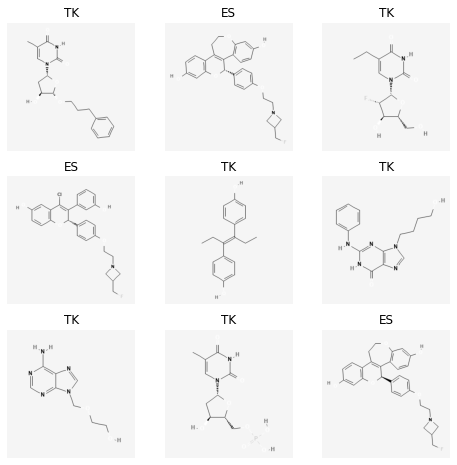

In [8]:
# 先畫一張大張的底部圖
labels_map = {
    0: "TK",
    1: "ES",
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    # 隨機挑一張圖，一個 sample 指的就是一張圖
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    # label 是這張圖的分類
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img[0],cmap='gray')
plt.show()

### 將input 及output打包 
torch.utils.data.TensorDataset(data_tensor, target_tensor)

https://pytorch.org/docs/stable/data.html

In [9]:
# Train = torch.utils.data.TensorDataset(feature_train, target_train)
# Test = torch.utils.data.TensorDataset(feature_test, target_test)

### Hyperparameter

In [10]:
LR = 0.01
batch_size = 100
n_iters = 10000
num_epochs = n_iters / (len(training_data) / batch_size)
# num_epochs = int(num_epochs)
num_epochs = 1000

https://blog.csdn.net/qq_34243930/article/details/107231539

https://github.com/vdumoulin/conv_arithmetic/blob/master/README.md


In [11]:
Train = training_data
Test = testing_data

In [12]:
train_loader = torch.utils.data.DataLoader(Train, batch_size = batch_size, shuffle = True)
test_loader = torch.utils.data.DataLoader(Test, batch_size = batch_size, shuffle = True)

Output = (Input+2p-f)/s+1

In [33]:
class CNN_model(nn.Module):
    def __init__ (self):
        super(CNN_model, self).__init__()
        # input (3, 300, 300)
        self.cnn1 = nn.Conv2d(in_channels=3, out_channels=4, kernel_size=3, stride=3, padding=0)
        self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)
        self.cnn2 = nn.Conv2d(in_channels=4, out_channels=8, kernel_size=3, stride=3, padding=0) 
        self.relu2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)
        #接一個fully connect (flat)
        n=8
        out = 8
        self.fc1 = nn.Linear(out*n*n, out*6*6) 
        self.fc2 = nn.Linear(out*6*6, 2) 
        
    def forward(self, x):
        out = self.cnn1(x)
        out = self.relu1(out)
        out = self.maxpool1(out)
        out = self.cnn2(out)
        out = self.relu2(out)
        out = self.maxpool2(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

### Optimize
https://blog.csdn.net/u011995719/article/details/88988420

In [34]:
model = CNN_model()
optimize = torch.optim.Adam(model.parameters(), lr=LR, momentum = 0.9)
loss_function = nn.CrossEntropyLoss()
input_shape = (-1, 3, 300, 300)

CNN_model(
  (cnn1): Conv2d(3, 4, kernel_size=(3, 3), stride=(3, 3))
  (relu1): ReLU()
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cnn2): Conv2d(4, 8, kernel_size=(3, 3), stride=(3, 3))
  (relu2): ReLU()
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=512, out_features=288, bias=True)
  (fc2): Linear(in_features=288, out_features=2, bias=True)
)


In [35]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [36]:
def fit_model(model, loss_func, optimizer, input_shape, num_epochs, train_loader, test_loader):

    training_loss = []
    training_accuracy = []
    validation_loss = []
    validation_accuracy = []
    
    for epoch in range(num_epochs):

        correct_train = 0
        total_train = 0
        for i, (images, labels) in enumerate(train_loader):

            # optimizer 每個batch都要歸0
            optimizer.zero_grad()
            train = Variable(images.view(input_shape))
            labels = Variable(labels)
            outputs = model(train)
            train_loss = loss_func(outputs, labels)
            train_loss.backward()
            optimizer.step()
            
            predicted = torch.max(outputs.data, 1)[1]
            total_train += len(labels)
            correct_train += (predicted == labels).float().sum()
        train_accuracy = 100 * correct_train / float(total_train)
        training_accuracy.append(train_accuracy)
        training_loss.append(train_loss.data)

        #evaluate model & store loss & acc / epoch
        correct_test = 0
        total_test = 0
        for images, labels in test_loader:
            test = Variable(images.view(input_shape))
            outputs = model(test)
            val_loss = loss_func(outputs, labels)
            predicted = torch.max(outputs.data, 1)[1]
            total_test += len(labels)
            correct_test += (predicted == labels).float().sum()
        val_accuracy = 100 * correct_test / float(total_test)
        validation_accuracy.append(val_accuracy)
        validation_loss.append(val_loss.data)
        if epoch%100 ==0:
            print('Train Epoch: {}/{} Traing_Loss: {} Traing_acc: {:.6f}% Val_Loss: {} Val_accuracy: {:.6f}%'.format(epoch+1, num_epochs, train_loss.data, train_accuracy, val_loss.data, val_accuracy))
    return training_loss, training_accuracy, validation_loss, validation_accuracy

In [37]:
training_loss, training_accuracy, validation_loss, validation_accuracy = fit_model(model, loss_function, optimize, input_shape, num_epochs, train_loader, test_loader)

Train Epoch: 1/1000 Traing_Loss: 3.9128189086914062 Traing_acc: 50.000000% Val_Loss: 155.04754638671875 Val_accuracy: 75.000000%
Train Epoch: 101/1000 Traing_Loss: 0.6931494474411011 Traing_acc: 50.000000% Val_Loss: 0.6938022375106812 Val_accuracy: 25.000000%
Train Epoch: 201/1000 Traing_Loss: 0.6931472420692444 Traing_acc: 50.000000% Val_Loss: 0.6931434273719788 Val_accuracy: 75.000000%
Train Epoch: 301/1000 Traing_Loss: 0.6931473016738892 Traing_acc: 50.000000% Val_Loss: 0.6931472420692444 Val_accuracy: 25.000000%
Train Epoch: 401/1000 Traing_Loss: 0.6931473016738892 Traing_acc: 50.000000% Val_Loss: 0.6931473016738892 Val_accuracy: 75.000000%
Train Epoch: 501/1000 Traing_Loss: 0.6931473016738892 Traing_acc: 50.000000% Val_Loss: 0.6931473016738892 Val_accuracy: 25.000000%
Train Epoch: 601/1000 Traing_Loss: 0.6931473016738892 Traing_acc: 50.000000% Val_Loss: 0.6931473016738892 Val_accuracy: 25.000000%
Train Epoch: 701/1000 Traing_Loss: 0.6931473016738892 Traing_acc: 50.000000% Val_Loss

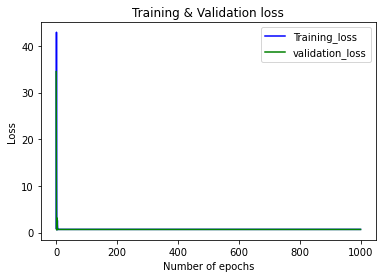

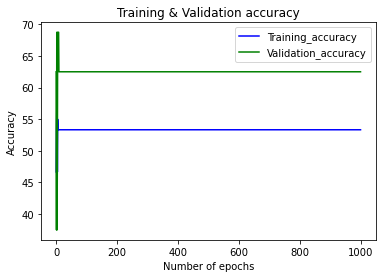

In [ ]:
num_epochs =1000
plt.plot(range(num_epochs), training_loss, 'b-', label='Training_loss')
plt.plot(range(num_epochs), validation_loss, 'g-', label='validation_loss')
plt.title('Training & Validation loss')
plt.xlabel('Number of epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
plt.plot(range(num_epochs), training_accuracy, 'b-', label='Training_accuracy')
plt.plot(range(num_epochs), validation_accuracy, 'g-', label='Validation_accuracy')
plt.title('Training & Validation accuracy')
plt.xlabel('Number of epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
# def fit_model(model, loss_func, optimizer, input_shape, num_epochs, train_loader, test_loader):

#     training_loss = []
#     training_accuracy = []
#     validation_loss = []
#     validation_accuracy = []
#     for epoch in range(num_epochs):
     
#         correct_train = 0
#         total_train = 0
#         for i, (images, labels) in enumerate(train_loader):
#             train = Variable(images.view(input_shape))
#             labels = Variable(labels)
#             # clear gradioet
#             optimize.zero_grad()
            
            

https://blog.csdn.net/scut_salmon/article/details/82414730

In [ ]:

# optimizer.zero_grad()

# =

# weights = [0] * n
# alpha = 0.0001
# max_Iter = 50000
# for i in range(max_Iter):
#     loss = 0
#     d_weights = [0] * n ============等於這一行梯度規0
#     for k in range(m):
#         h = dot(input[k], weights)
#         d_weights = [d_weights[j] + (label[k] - h) * input[k][j] for j in range(n)] 
#         loss += (label[k] - h) * (label[k] - h) / 2
#     d_weights = [d_weights[k]/m for k in range(n)]
#     weights = [weights[k] + alpha * d_weights[k] for k in range(n)]
#     if i%10000 == 0:
#         print "Iteration %d loss: %f"%(i, loss/m)



https://blog.csdn.net/weixin_42782150/article/details/106854349

In [ ]:
# train = Variable(images.view((-1,1,28,28)))
# print(train)
